In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [74]:
import pandas as pd
import numpy as np

In [75]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [77]:
from collections import Counter

In [78]:
from imblearn.under_sampling import RandomUnderSampler

In [79]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [80]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [81]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'accuracy = {accuracy}')
    recall = (tp) / (tp + fn)
    print(f'recall = {recall}')
    precision = (tp) / (tp + fp)
    print(f'precision = {precision}')
    print(f'tn:{tn} fp:{fp} fn:{fn} tp:{tp}')

In [82]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [83]:
import os
import glob
import pandas as pd

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
df2020 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv'
df2019 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv'

#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [84]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [85]:
def filter_keyword(df, keyword):
    df[keyword] = df.apply(return_pol_gov, axis=1)    
    df = df[df[keyword] == True]
    oped_v_news(df)
    return df

In [86]:
printed_2020 = printed(df2020)
printed_2019 = printed(df2019)

In [87]:
print(printed_2020.shape)
print(printed_2019.shape)

(27752, 5)
(30232, 5)


In [88]:
#concat df together
df = pd.concat([printed_2019, printed_2020])

In [89]:
%%time
df = df.copy()

CPU times: user 6.95 ms, sys: 783 µs, total: 7.73 ms
Wall time: 7.93 ms


In [90]:
df.shape

(57984, 5)

In [91]:
df.text.iloc[0]

'North Carolina’s secretary of health on Friday called for an investigation into a hospital where doctors had suspected children with complex heart conditions had been dying at higher than expected rates after undergoing heart surgery.Dr. Mandy Cohen, the secretary, said in a statement that a team from the state’s division of health service regulation would work with federal regulators to conduct a “thorough investigation” into events that occurred in 2016 and 2017 at North Carolina Children’s Hospital, part of the University of North Carolina medical center in Chapel Hill.“As a mother and a doctor my heart goes out to any family that loses a child,” Dr. Cohen said in the statement. “Patient safety, particularly for the most vulnerable children, is paramount.”The investigation is in response to an article published by The New York Times on Thursday, which gave a detailed look inside the medical institution as cardiologists grappled with whether to keep sending their young patients ther

In [92]:
(df.iloc[0])

print_page                                                       13.0
keywords            [{'name': 'subject', 'value': 'Hospitals', 'ra...
pub_date                                     2019-06-01T00:03:16+0000
type_of_material                                                 News
text                North Carolina’s secretary of health on Friday...
Name: nyt://article/4b1e8a16-71b7-5fac-b1cc-87b459a0a5dd, dtype: object

In [93]:
(df.iloc[0])

print_page                                                       13.0
keywords            [{'name': 'subject', 'value': 'Hospitals', 'ra...
pub_date                                     2019-06-01T00:03:16+0000
type_of_material                                                 News
text                North Carolina’s secretary of health on Friday...
Name: nyt://article/4b1e8a16-71b7-5fac-b1cc-87b459a0a5dd, dtype: object

In [94]:
df.shape

(57984, 5)

# filter keywords

In [95]:
df = filter_keyword(df)

NameError: name 'oped_v_news' is not defined

In [ ]:
df.shape

In [29]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [30]:
#turn series into list...
corpus = list(X)

In [31]:
# define y as a series of op-ed or news
y = df.type_of_material

In [32]:
vectorize_y_ser(y)

_id
nyt://article/4b1e8a16-71b7-5fac-b1cc-87b459a0a5dd    0
nyt://article/2c929a23-32cb-5794-a320-2a254caa6dc1    0
nyt://article/49a7077e-85df-5fef-a886-a9503d73c657    0
nyt://article/ea6418b4-c464-5be4-86ef-f465d38dade2    0
nyt://article/0ae91997-445f-5dd6-89a6-ea3cf6a550a6    0
                                                     ..
nyt://article/a4383433-5708-530c-bf78-2ec5ee0d96cd    0
nyt://article/aff30fb5-0177-5fed-b8b5-55656f2672f6    0
nyt://article/d67ea079-eaf8-5e69-a77c-3138a3fc91cb    0
nyt://article/5af20a48-6f66-5bae-a9fd-948268ed38cf    0
nyt://article/3aea061c-d11a-53d1-8480-c0b163740360    0
Name: type_of_material, Length: 57984, dtype: int64

In [33]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 22.5 ms, sys: 2.42 ms, total: 24.9 ms
Wall time: 24.4 ms


In [34]:
y.value_counts()

0    53972
1     4012
Name: type_of_material, dtype: int64

In [35]:
y.shape

(57984,)

# remove stop words

# stemming/lemmatization

In [36]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [37]:
%%time
def snowball_tokenize(doc):
    snowball = SnowballStemmer('english')
    return [snowball.stem(word) for word in word_tokenize(doc.lower())]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [38]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


# vectorizer

# SNOWBALL tfidf

In [39]:
# %%time
# #create vectorizer

# snow_vectorizer = TfidfVectorizer(#input='content', 
# #                 encoding='utf-8', 
# #                 decode_error='strict', 
#                  strip_accents='ascii', 
#                  lowercase=True, 
# #                 preprocessor=None, 
#                  tokenizer=snowball_tokenize, 
# #                 analyzer='word', 
#                  stop_words='english', 
# #                 token_pattern='(?u)\b\w\w+\b', 
# #                 ngram_range=(1, 1), 
#                  max_df=0.90, 
#                  min_df=0.10, 
#                  max_features=None, 
# #                 vocabulary=None, 
# #                 binary=False, 
# #                 dtype=<class 'numpy.float64'>, 
# #                 norm='l2', 
# #                 use_idf=True, 
# #                 smooth_idf=True, 
# #                 sublinear_tf=False
# )

<!-- /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent)) -->

# WORDNET tfidf

In [40]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’':
            document = document.replace(char, " ")
            
    return document

In [41]:
stop_words = ['a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'mr','ms', 'said']


In [42]:
%%time
#create vectorizer

wordnet_vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=stop_words, 
#                 token_pattern='(?u)\b\w\w+\b', 
                 ngram_range=(1, 1), 
                 max_df=0.9, 
                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 41 µs, sys: 0 ns, total: 41 µs
Wall time: 45.1 µs


# test, train, split

In [43]:
#test, train, split 

In [44]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(43488,) (14496,) (43488,) (14496,)
CPU times: user 44.6 ms, sys: 3.95 ms, total: 48.6 ms
Wall time: 47.7 ms


In [45]:
%%time
print(datetime.datetime.now())
X_train =  wordnet_vectorizer.fit_transform(X_train)

2021-01-07 10:32:15.746374
CPU times: user 6min 4s, sys: 3.71 s, total: 6min 7s
Wall time: 6min 11s


In [46]:
%%time
print(datetime.datetime.now())
X_test = wordnet_vectorizer.transform(X_test)

2021-01-07 10:38:27.045110
CPU times: user 2min 1s, sys: 1.29 s, total: 2min 2s
Wall time: 2min 4s


In [47]:
vocab = wordnet_vectorizer.vocabulary_

In [48]:
len(vocab)

892

In [49]:
X_train.shape

(43488, 892)

In [50]:
X_test.shape

(14496, 892)

# count vectorizer

In [51]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [52]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 2988), (1, 2988)]
RandomUnderSampler(random_state=0)
CPU times: user 28.9 ms, sys: 3.65 ms, total: 32.5 ms
Wall time: 31.9 ms


# random forest classifier

In [53]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)


2021-01-07 10:40:31.299469
CPU times: user 158 µs, sys: 56 µs, total: 214 µs
Wall time: 192 µs


In [54]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(14496,)

### metrics y_pred

In [55]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [56]:
print(y_test.shape)
print(y_pred.shape)

(14496,)
(14496,)


In [57]:
metrics_(tn, fp, fn, tp)

accuracy = 0.8272626931567328
recall = 0.8388671875
precision = 0.2686053783614759
tn:11133 fp:2339 fn:165 tp:859


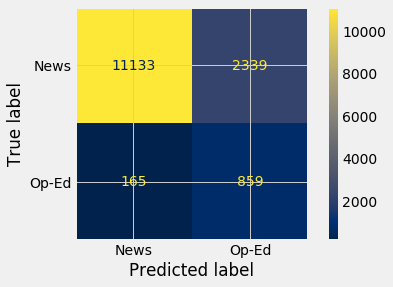

In [100]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                     cmap='cividis')

plt.savefig('../img/confusion_matrix.png');

# important features

### feature imporance

2021-01-07 11:02:06.441387
CPU times: user 347 ms, sys: 15.3 ms, total: 362 ms
Wall time: 361 ms


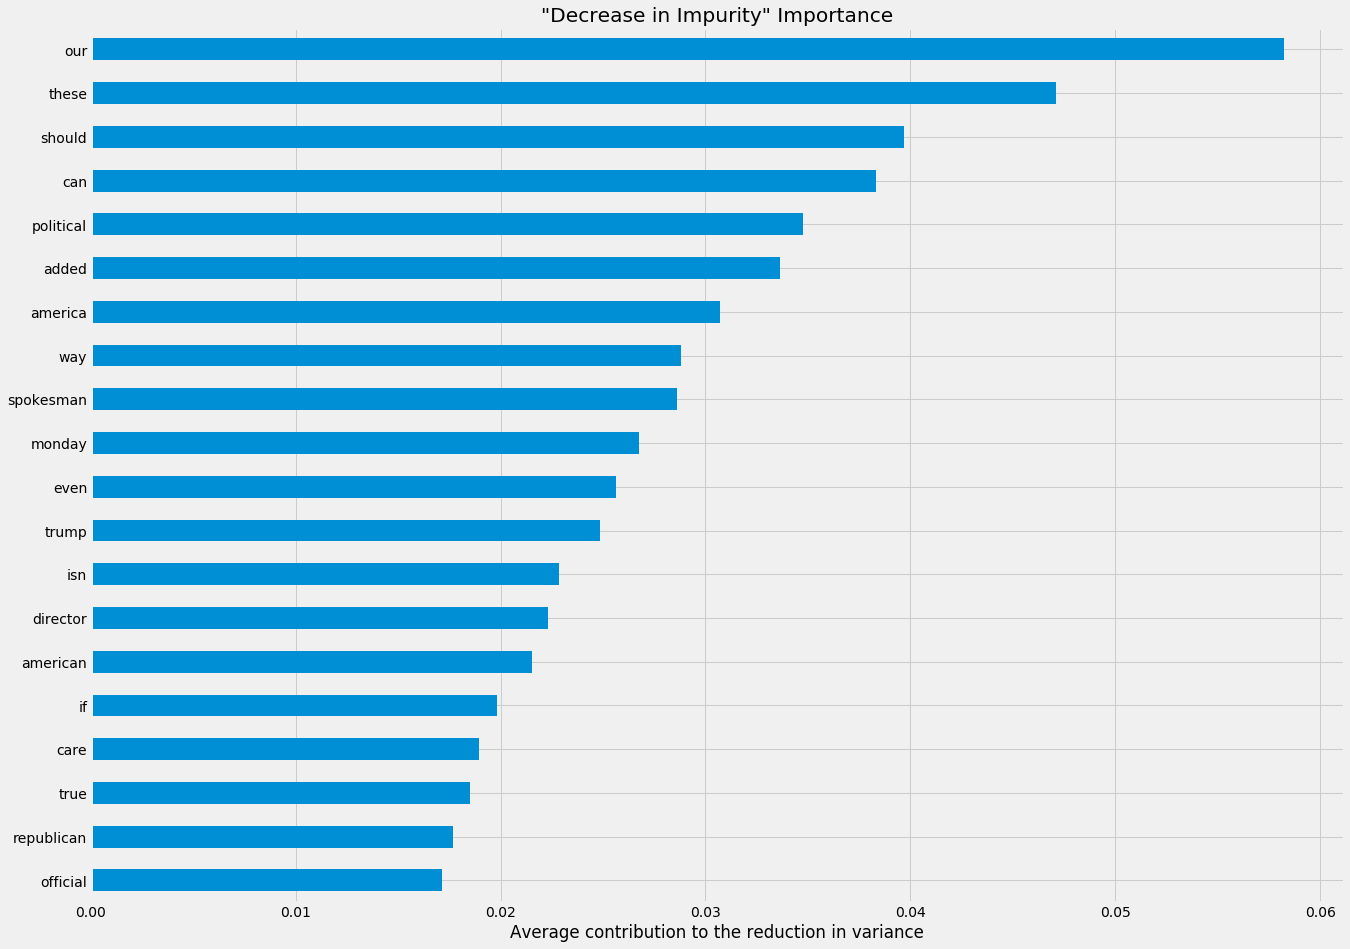

In [99]:
%%time
print(datetime.datetime.now())

feat_names = wordnet_vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import,
                           index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('../img/feature_imporance.png');

### permutation importance

In [60]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [61]:
len(feat_names)

892

In [62]:
feat_names

['000',
 '1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '25',
 '3',
 '30',
 '4',
 '40',
 '5',
 '50',
 '500',
 '6',
 '60',
 '7',
 '8',
 '9',
 'ability',
 'able',
 'about',
 'access',
 'according',
 'account',
 'accused',
 'across',
 'act',
 'action',
 'actually',
 'added',
 'adding',
 'address',
 'administration',
 'after',
 'again',
 'against',
 'age',
 'agency',
 'ago',
 'agreed',
 'ahead',
 'air',
 'all',
 'allow',
 'allowed',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'america',
 'american',
 'among',
 'amount',
 'announced',
 'another',
 'answer',
 'any',
 'anyone',
 'anything',
 'appeared',
 'approach',
 'april',
 'are',
 'area',
 'around',
 'art',
 'ask',
 'asked',
 'attack',
 'attempt',
 'attention',
 'authority',
 'available',
 'avoid',
 'away',
 'back',
 'bad',
 'based',
 'became',
 'because',
 'become',
 'been',
 'before',
 'began',


In [63]:
stop_words = wordnet_vectorizer.stop_words_

In [64]:
len(stop_words)

211923

# save model as pickle file

In [65]:
filename = '/Users/djbetts/Desktop/full_dataset.pkl'

In [66]:
#pickle.dump(rf_clf, open(filename, 'wb'))

In [67]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [68]:
#loaded_model.fit(X_resampled, y_resampled)

In [69]:
#result = loaded_model.score(X_resampled, y_resampled)